<a href="https://colab.research.google.com/github/andygma567/X-Ray-Image-Classification/blob/main/CNN_for_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

We build a CNN using the Keras Tuner. Our model searches over a space of hyperparameters of number of filters, using batch normalization layers, and number of nodes per dense layer at the top of the model. 

After training on ~250 images my best CNN has an accuracy of 94% on 66 testing images. 

# Introduction

I followed this tutorial for using preprocessing layers in my model:
https://www.tensorflow.org/guide/keras/preprocessing_layers

I also used the image classification tutorial from tensorflow:
https://www.tensorflow.org/tutorials/images/classification

and the Keras Tuner tutorials:
https://keras.io/guides/keras_tuner/getting_started/

# Set Up

In [72]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np # I'm not sure if I need this one
import os 

#for reproducibility of result I use the same seed for the random number generator
tf.random.set_seed(42) 

print(tf.__version__)

2.8.2


In [73]:
# Get the gpu info 

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug 15 09:19:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |   1103MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [74]:
data_dir = '/content/drive/MyDrive/X-Ray classification/classification-challenge-starter/Covid19-dataset/'

# I use the same seed for reproducability
SEED = 123 

# Because the X-rays are in grayscale I wanted to bring in the image files 
# in grayscale. I also wanted to try using the categorical label mode

# This is my training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'train', 
    validation_split=0.2,
    subset="training",
    seed = SEED,
    label_mode = 'categorical', 
    color_mode='grayscale')

# This is my validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'train', 
    validation_split=0.2,
    subset="validation",
    seed = SEED, 
    label_mode = 'categorical', 
    color_mode='grayscale')

# This is my testing set
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir + 'test', 
    seed = SEED, 
    label_mode = 'categorical', 
    color_mode='grayscale')

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [75]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Pneumonia']


Here I try to optimize my data pipeline setup. It's definitely not necessary for my small dataset but I think it's a good habit for me to always do this step. I follow the tutorials from tensorflow:
https://www.tensorflow.org/guide/data_performance

In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Using Data Augmentation Layers

Data augmentation is useful for training with small datasets. By applying small shifts, zooming, rotations, etc. the CNN will be less likely to overfit the small dataset. 

Tensorflow allows models to be built with preprocessing layers in it so that unprocessed images may be handed to the model. This helps for sharing and deploying the model later on. 

In this subsection we will review the kinds of images and image preprocessing that our models will use.

## Display the Images

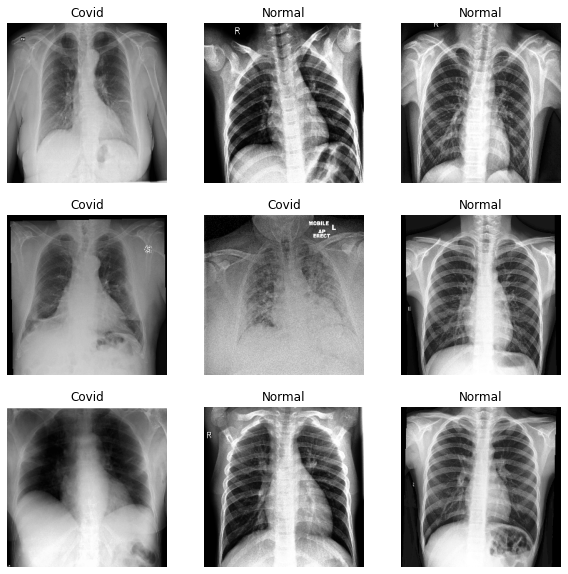

In [77]:
# Because I used 'categorical' as an encoding then I need to treat the labels with
# tf.argmax 

# I need to use tf.squeeze() in order to remove dimensions of size 1 since I'm using grayscale images
# this kind of reshaping allows plt.imshow to interpret the images as a 2D array instead of a 3D array

plt.figure(figsize=(10, 10))
# I think take(1) means it takes one batch but I'm not entirely sure...
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # the last 3 parameters are needed for gray scale images
    plt.imshow(tf.squeeze(images[i].numpy().astype('float32')), cmap = 'gray', vmin = 0, vmax = 255)
    plt.title(class_names[tf.argmax(labels[i], axis = 0)])
    plt.axis("off")

## Make an example Data Augmentation Model

For my data preprocessing I've decided to use flips, rotations, shifts, and zoom. 

In [78]:
# the data augmentation example will be a Sequential Model
data_augmentation = keras.Sequential()
data_augmentation.add(layers.Input(shape = (256, 256, 1)))

# we rescale by 255 because the grayscale pixels range from 0 to 255
data_augmentation.add(layers.Rescaling(
    1./255))
data_augmentation.add(layers.RandomFlip(
    "horizontal_and_vertical"))
# Zoom in or out by 5%
data_augmentation.add(layers.RandomZoom(height_factor = .15, width_factor= .15))
# Rotate by about 15 degrees - that's a little over 4%
data_augmentation.add(layers.RandomRotation(
     factor = .04))
#Translate by up to 3% up, down, left, or right
data_augmentation.add(layers.RandomTranslation(
    height_factor = 0.1,
    width_factor = 0.1))

print(data_augmentation.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 256, 256, 1)       0         
                                                                 
 random_flip_14 (RandomFlip)  (None, 256, 256, 1)      0         
                                                                 
 random_zoom_14 (RandomZoom)  (None, 256, 256, 1)      0         
                                                                 
 random_rotation_14 (RandomR  (None, 256, 256, 1)      0         
 otation)                                                        
                                                                 
 random_translation_14 (Rand  (None, 256, 256, 1)      0         
 omTranslation)                                                  
                                                                 
Total params: 0
Trainable params: 0
Non-trainable par

Now we test the data augmentation on one image from the training dataset. 

Min and max pixel values of original image: 0.0 255.0
Min and max pixel values of augmented image: 0.001608017 0.940859


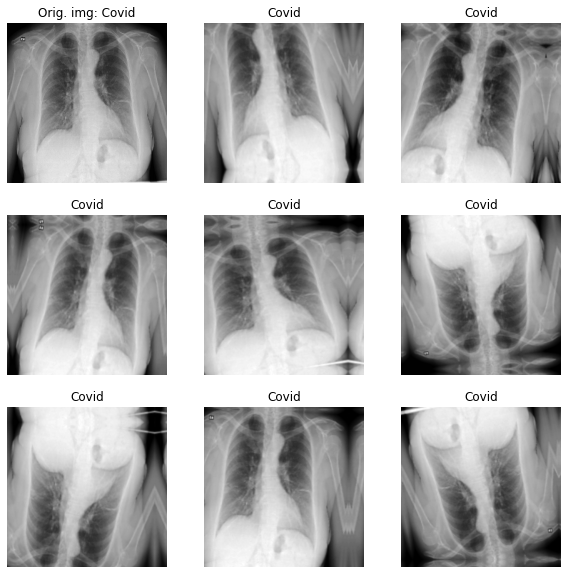

In [79]:
# We take one batch from the training dataset
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 10))
# The first image is the original, unaltered image
ax = plt.subplot(3, 3, 1)
plt.imshow(tf.squeeze(images[0].numpy().astype("float32")), cmap = 'gray')
plt.title('Orig. img: ' + class_names[tf.argmax(labels[0], axis = 0)])
plt.axis("off")

# Next we print a sequence of randomly augmented images
for i in range(1, 9):
    # I set the training parameter to be true because the tensorflow
    # preprocessing layers only work while in training mode 
    augmented_images = data_augmentation(images, training = True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(augmented_images[0].numpy().astype("float32")), cmap = 'gray')
    plt.title(class_names[tf.argmax(labels[0], axis = 0)])
    plt.axis("off")

# Check that the pixel value of the image has been rescaled to be in [0, 1]
print("Min and max pixel values of original image:", 
      images[0].numpy().min(), 
      images[0].numpy().max())
print("Min and max pixel values of augmented image:", 
      augmented_images[0].numpy().min(), 
      augmented_images[0].numpy().max())

# Build a Model to use with the Keras Tuner

In [80]:
# Install the keras-tuner
!pip install keras-tuner -q 


When working with the Keras Tuner I like to subclass the Hypermodel class in the Keras Tuner. This allows me to also tune the training, inference, preprocessing, etc. later if I wanted. Another alternative way to set up the Keras Tuner could be to write a model building function. 

In this example, my model is a standard CNN with  preprocessing layers and the option of using batch normalization. The model allows for various numbers of filters, pool sizes, and nodes per dense layers at the top of the model. However, I only use 3x3 filters in the convolution layers in order to save time on searching the space of hyperparameters. 

In [81]:
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        # The images are (256, 256, 1)
        # There is only 1 channel because this is grayscale and not rgb
        model.add(keras.Input(shape = (256, 256, 1)))
        # These are my preprocessing layers
        model.add(layers.Rescaling(
            1./255))
        model.add(layers.RandomFlip(
            "horizontal_and_vertical"))
        # Zoom in or out by 5%
        model.add(layers.RandomZoom(height_factor = .15, width_factor= .15))
        # Rotate by about 15 degrees - that's a little over 4%
        model.add(layers.RandomRotation(
            factor = .04))
        #Translate by up to 3% up, down, left, or right
        model.add(layers.RandomTranslation(
            height_factor = 0.1,
          width_factor = 0.1))

        # choose pool size
        POOL_SIZE = hp.Int('pool', min_value = 2, max_value = 4)
        # I only use 3x3 size filters to save time on training
        # If normalize is true then I use batch normalization
        NORMALIZE = hp.Boolean('normalize')
        # I decided not to tune the dropout either to save time

        model.add(keras.layers.Conv2D(
            hp.Int('num_channels_1', min_value = 8, max_value = 16, step = 4), 
            3, strides = 1, padding='same', activation='relu'))
        if NORMALIZE: model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size= POOL_SIZE))

        model.add(keras.layers.Conv2D(
            hp.Int('num_channels_2', min_value = 8, max_value = 16, step = 4), 
            3, strides = 1, padding='same', activation='relu'))        
        if NORMALIZE: model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size= POOL_SIZE))

        model.add(keras.layers.Conv2D(
            hp.Int('num_channels_3', min_value = 8, max_value = 16, step = 4), 
            3, strides = 1, padding='same', activation='relu'))  
        if NORMALIZE: model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size= POOL_SIZE))

        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Flatten())

        # I added in two layers of fully connected
        model.add(keras.layers.Dense(
            hp.Int('num_nodes_1', min_value = 16, max_value = 128, step = 32),
            activation="relu"))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(
            hp.Int('num_nodes_2', min_value = 16, max_value = 128, step = 32),
            activation="relu"))        
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(3,activation="softmax"))

        LEARNING_RATE = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate= LEARNING_RATE),
            loss="categorical_crossentropy",
            metrics=['categorical_accuracy']
            )
  
        return model

## Make a Keras Tuner

I'm using the Hyperband style of searching for Hyperparameters. I discuss what this is a little more in my other repository "Portfolio Project #1". Roughly speaking it's the newest style of Hyperparameter tuning that works by setting up many different models in tournament-style of training. After some incremental training the best models are kept while the under performing models are discarded. 

In [82]:
# Create a Hyperband Tuner 
tuner = kt.Hyperband(hypermodel = MyHyperModel(),
    objective='val_loss',
    max_epochs = 3,
    factor=3, 
    executions_per_trial=1, 
    overwrite = False,
    # Set a directory to store the intermediate results.
    directory="drive/MyDrive/X-Ray classification/CNN/tuning_search", 
    project_name="intro_to_CNN"
    )

## Search the Space of Hyperparameters

In [83]:
# Create an early stopping callback to save time on training
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience=5)

# Search the parameter space
tuner.search(
    train_ds, 
    validation_data = val_ds, 
    callbacks=[es]
    )

## Show the results of the Tuner search

In [84]:
# Print the best parameters
tuner.results_summary(num_trials=1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build a model
model = tuner.hypermodel.build(best_hps)

print(model.summary())

Results summary
Results in drive/MyDrive/X-Ray classification/CNN/tuning_search/intro_to_CNN
Showing 1 best trials
Trial summary
Hyperparameters:
pool: 3
normalize: True
num_channels_1: 8
num_channels_2: 8
num_channels_3: 16
num_nodes_1: 112
num_nodes_2: 16
learning_rate: 0.001
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.9155088067054749
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 256, 256, 1)       0         
                                                                 
 random_flip_16 (RandomFlip)  (None, 256, 256, 1)      0         
                                                                 
 random_zoom_16 (RandomZoom)  (None, 256, 256, 1)      0         
                                                                 
 random_rotation_16 (RandomR  (None, 256, 256, 1)      0         
 otatio

# Use the Best Model from the Tuner Search

## Set up Checkpoint Callbacks

In [85]:
# save one checkpoint at a time into my drive
checkpoint_path = "drive/MyDrive/X-Ray classification/CNN/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [86]:
# Create a callback that saves the model's weights while training
cp = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=True,
                                        save_best_only=True,
                                        verbose=1)

## Create an Optimally Tuned Model

In [87]:
# Create a copy of the best found model 
tuned_model = tuner.hypermodel.build(best_hps)

# Retrain the model
history = tuned_model.fit(train_ds, validation_data = val_ds, epochs=80, callbacks=[cp])

Epoch 1/80
7/7 [==============================] - ETA: 0s - loss: 1.6323 - categorical_accuracy: 0.4478
Epoch 1: val_loss improved from inf to 1.10183, saving model to drive/MyDrive/X-Ray classification/CNN/training/cp.ckpt
7/7 [==============================] - 2s 88ms/step - loss: 1.6323 - categorical_accuracy: 0.4478 - val_loss: 1.1018 - val_categorical_accuracy: 0.2400
Epoch 2/80
7/7 [==============================] - ETA: 0s - loss: 0.9521 - categorical_accuracy: 0.6070
Epoch 2: val_loss improved from 1.10183 to 1.08799, saving model to drive/MyDrive/X-Ray classification/CNN/training/cp.ckpt
7/7 [==============================] - 0s 37ms/step - loss: 0.9521 - categorical_accuracy: 0.6070 - val_loss: 1.0880 - val_categorical_accuracy: 0.3400
Epoch 3/80
7/7 [==============================] - ETA: 0s - loss: 0.9234 - categorical_accuracy: 0.5174
Epoch 3: val_loss improved from 1.08799 to 0.99977, saving model to drive/MyDrive/X-Ray classification/CNN/training/cp.ckpt
7/7 [===========

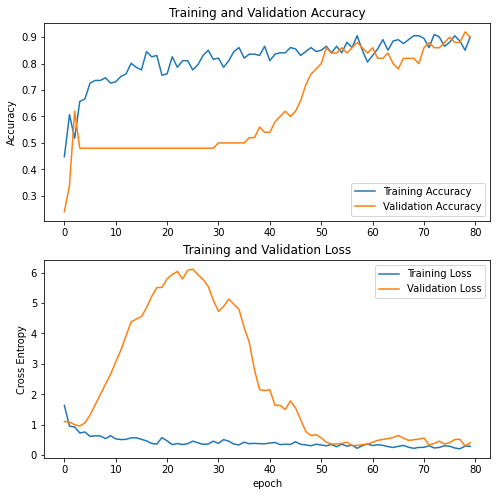

In [88]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Load an Optimal Model from the Optimal Training Checkpoint 

In [89]:
# We load a model using our best saved checkpoint
best_model = tuner.hypermodel.build(best_hps)
best_model.load_weights(checkpoint_path)

# Evaluate the Best Model

In [90]:
best_loss, best_acc = best_model.evaluate(test_ds)
print('Tuned model with best val_loss epoch')

3/3 [==============================] - 0s 7ms/step - loss: 0.3266 - categorical_accuracy: 0.9394
Tuned model with best val_loss epoch


## Compare the Optimized Model with a Previously Saved Model

In [91]:
old_model = tf.keras.models.load_model('drive/MyDrive/X-Ray classification/CNN/saved_model/my_model')

old_loss, old_acc = old_model.evaluate(test_ds)
print("Old saved model")

3/3 [==============================] - 0s 9ms/step - loss: 0.4030 - categorical_accuracy: 0.7879
Old saved model


In [96]:
# If the new model performs better then we save it over our previous model
if old_acc < best_acc: 
  print('Saved best_model over the prev model')
  best_model.save('/drive/MyDrive/X-Ray classification/CNN/saved_model/my_model')
else:
  best_model = old_model

Saved best_model over the prev model


# Classification Report and Confusion Matrix

A (i, j) entry in a confusion matrix means that the true label was class_i but the model predicted class_j. This confusion matrix is also normalized so that it sums to 1. 

In [97]:
y_pred = tf.argmax(best_model.predict(test_ds), axis = 1).numpy()

ds = test_ds.take(-1).unbatch()
y_true = [y for x, y in ds] 
y_true = tf.argmax(y_true, axis = 1).numpy()

              precision    recall  f1-score   support

       Covid       1.00      0.92      0.96        26
      Normal       0.91      1.00      0.95        20
   Pneumonia       0.90      0.90      0.90        20

    accuracy                           0.94        66
   macro avg       0.94      0.94      0.94        66
weighted avg       0.94      0.94      0.94        66



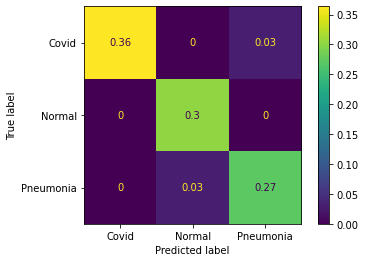

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names = class_names))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels= class_names)
disp.plot()